# 06. サブグループ分析（Subgroup Analysis: New Grads vs Experienced）

## 📌 このノートで示すこと（TL;DR）
本ノートは、都道府県別データの回帰モデルで観測された「全体モデルの限界」を出発点に、離職の構造が **新卒（New Grads）** と **既卒（Experienced）** で異なる可能性を検証する。

- **問い**：全体モデルで効いた要因（夜勤負荷・求人倍率・住宅コスト等）は、サブグループでも同様に通用するのか？
- **狙い**：サブグループ別にモデルを組み直し、構造差（どの要因がどちらに効くか）を明確化する
- **位置づけ**：ここで得た構造差を、後続の解釈・提言（施策の分岐設計）に接続するための検証ノート

---

## 🔎 Notebook Purpose（目的）
全体モデル（Model D）では説明しきれなかった **「新卒」と「既卒」の離職構造の乖離** を、データに基づいて分解・検証する。

---

## 📥 Input（前提：データと実行順）
-  統合マスターデータ（都道府県 × 公的統計、基準年は概ね2023年）`/data/processed/nurse_data_clean.csv` を使用。<br>将来的には ETL パイプライン化により再現性を担保する予定。
- 上流（Upstream）：マスターデータセット作成ノート（例：`01_create_master_dataset.ipynb`）で生成された processed データを前提とする  
  ※リポジトリ構成によりノート名が異なる場合は、`data/processed/` 配下を生成するノートを先に実行すること

---

## 📤 Output（このノートの成果物）
- 新卒／既卒それぞれの回帰モデル（係数・当てはまり・主要な示唆）
- サブグループ間で「効く要因」が変わるかの検証結果
- 都市部の生活コスト圧（住宅コスト×所得水準）の定量比較（必要に応じて）

---

## 🧭 分析ステップ（設計）
### Step 1: 全体モデルの適用検証
全体モデル（Model D）の説明変数セットを、新卒／既卒にそのまま適用し、一般化できない点（限界）を確認する。

### Step 2: 既卒モデルの探索（Regional Anchor Hypothesis）
仮説：既卒は「地域への定住性（例：持ち家率）」や「生活の安定性」によって離職が抑制されている可能性がある。

### Step 3: 新卒モデルの探索（Urban Cost Pressure Hypothesis）
仮説：新卒は都市部の「生活コスト圧（家賃など）」や「競争環境（求人倍率など）」の影響を強く受けている可能性がある。

### Step 4: 経済ギャップの検証（Economic Gap Analysis）
都市部における「住宅コスト」と「所得水準」の相対関係を定量化し、サブグループ差の背景として整合するかを検証する。

---

> **注意（解釈上の前提）**  
> 本分析は都道府県単位の集計データに基づくため、因果の断定ではなく「構造の示唆」を目的とする。


In [1]:
# ---------------------------------------------------------
# 1. 分析の準備（ライブラリとデータの読み込み）
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
from IPython.display import display
import japanize_matplotlib

# グラフ設定
sns.set_theme(style="whitegrid", font="Hiragino Sans")
plt.rcParams["figure.figsize"]= (10,6)

# データ読み込み
DATA_PATH = Path("../data/processed/nurse_data_clean.csv")
df = pd.read_csv(DATA_PATH)

print("Loaded", df.shape)
display(df.head())

Loaded (47, 23)


,prefecture,turnover_total,nurse_per_100k,annual_income,night_shift_72h_plus,metro_a,metro_b,job_openings_ratio,turnover_new_grad,turnover_experienced,...,hospital_count,large_hospital_count,large_hospital_ratio,hospital_per_100k,population,overtime_hours,night_shift_3_avg,night_shift_2_avg,average_age,population_density
0,北海道,11.5,1306.9,478.90,36.7,0,0,1.12,5.9,16.6,...,534,17,3.18,10.5,5092,5,7.8,4.6,42.0,64.9
1,青森県,8.6,1118.2,435.22,36.5,0,0,1.30,10.7,16.7,...,89,3,3.37,7.5,1184,5,7.7,4.8,42.0,122.8
2,岩手県,6.8,1217.9,458.97,11.8,0,0,1.32,7.8,19.1,...,91,2,2.20,7.8,1163,3,7.5,4.1,46.0,76.1
3,宮城県,9.1,934.4,535.80,30.2,0,0,1.34,7.1,12.4,...,135,7,5.19,6.0,2264,6,8.0,4.7,40.0,310.9
4,秋田県,7.4,1265.3,524.81,25.1,0,0,1.47,5.0,7.3,...,64,3,4.69,7.0,914,4,7.7,4.3,44.9,78.5


In [2]:
# ---------------------------------------------------------
# 2. ヘルパー関数の定義と分析対象の設定
# ---------------------------------------------------------

# 分析のターゲット変数（目的変数）を設定#
target_new = "turnover_new_grad"          # 新卒採用者離職率（New Grads）
target_experienced = "turnover_experienced" # 既卒採用者離職率（Experienced / Mid-career）

# 確認用メモ
# turnover_new_grad = (年度内退職者 / 当該年度新卒採用者) * 100
# turnover_experienced = (年度内退職者 / 当該年度既卒採用者) * 100

# モデル構築用の関数（仕様は変更なし）
def fit_ols(data, y, x_cols):
    """
    指定されたデータと変数でOLS（最小二乗法）モデルを構築して返す関数
    """
    # 必要なカラムだけで欠損除去
    temp_df = data[[y] + x_cols].dropna()
    
    # 説明変数に定数項（切片）を追加
    X = sm.add_constant(temp_df[x_cols])
    y_vals = temp_df[y]
    
    # モデルの学習（Fit）
    return sm.OLS(y_vals, X).fit()

print(f"分析対象を設定しました: {target_new}, {target_experienced}")

分析対象を設定しました: turnover_new_grad, turnover_experienced


In [3]:
# ---------------------------------------------------------
# Step 1: 全体モデル（Model D）の適用検証
# ---------------------------------------------------------

# Model D の特徴量セット
features_model_d = ["rent_private", "night_shift_72h_plus", "job_openings_ratio"]

# 各ターゲットに対してモデルを適用
m_new_d = fit_ols(df, target_new, features_model_d)
m_experienced_d = fit_ols(df, target_experienced, features_model_d) # 変数名変更

print("\n=== Model D 適用結果（Adj. R2 Comparison） ===")
print(f"全体 (Reference) : 0.810 (Model_D)")
print(f"新卒 (New Grads) : {m_new_d.rsquared_adj:.3f}  <-- 適合せず")
print(f"既卒 (Experienced): {m_experienced_d.rsquared_adj:.3f}  <-- 適合せず") # 表示名も変更

print("\n>> 考察: 全体モデルは「平均の罠」であった。新卒と既卒は全く異なるロジックで動いている。")


=== Model D 適用結果（Adj. R2 Comparison） ===
全体 (Reference) : 0.810 (Model_D)
新卒 (New Grads) : 0.077  <-- 適合せず
既卒 (Experienced): 0.127  <-- 適合せず

>> 考察: 全体モデルは「平均の罠」であった。新卒と既卒は全く異なるロジックで動いている。


In [4]:
# Step 2: 探索的分析 (1) 数値的アプローチ
# ---------------------------------------------------------
# 目的：まずは数値（相関係数）で、何が離職率に影響しているか「当たり」をつける

# 数値データのみ抽出
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 相関の計算
corr_exp = df[numeric_cols].corrwith(df[target_experienced])
corr_new = df[numeric_cols].corrwith(df[target_new])

# ランキング表示関数
def show_ranking(corr_series, target_name, title):
    print(f"\n{'='*20} {title} {'='*20}")
    
    # 自分自身を除外
    clean_series = corr_series.drop(target_name, errors='ignore')

    # 絶対値ランキング（影響力の強さ）
    print("★絶対値ランキング (Top 5 Impact)")
    abs_rank = clean_series.abs().sort_values(ascending=False).head(5)
    display(pd.DataFrame(abs_rank, columns=["Abs Coefficient"]))

    # 正の相関（悪化要因）
    print("▼ 正の相関 (Top 3 Risk Factors)")
    display(clean_series.sort_values(ascending=False).head(3))

    # 負の相関（抑制要因）
    print("▼ 負の相関 (Top 3 Save Factors)")
    display(clean_series.sort_values(ascending=True).head(3))

# 表示実行
show_ranking(corr_exp, target_experienced, "既卒 (Experienced) の分析")
show_ranking(corr_new, target_new, "新卒 (New Grads) の分析")


==================== 既卒 (Experienced) の分析 ====================
★絶対値ランキング (Top 5 Impact)


,Abs Coefficient
home_ownership_rate,0.449405
turnover_total,0.407347
job_openings_ratio,0.402539
hospital_count,0.345331
large_hospital_ratio,0.267441


▼ 正の相関 (Top 3 Risk Factors)


turnover_total       0.407347
hospital_count       0.345331
turnover_new_grad    0.252459
dtype: float64

▼ 負の相関 (Top 3 Save Factors)


home_ownership_rate    -0.449405
job_openings_ratio     -0.402539
large_hospital_ratio   -0.267441
dtype: float64


==================== 新卒 (New Grads) の分析 ====================
★絶対値ランキング (Top 5 Impact)


,Abs Coefficient
population_density,0.393475
hospital_count,0.359166
population,0.352676
large_hospital_count,0.330123
metro_b,0.300480


▼ 正の相関 (Top 3 Risk Factors)


population_density    0.393475
hospital_count        0.359166
population            0.352676
dtype: float64

▼ 負の相関 (Top 3 Save Factors)


home_ownership_rate   -0.260389
job_openings_ratio    -0.185138
night_shift_3_avg     -0.170348
dtype: float64

### 考察と可視化へのステップ
相関分析（Step 2-1）の結果、**キャリアステージによって離職のメカニズムが異なる**可能性が強く示唆されました。

1.  **新卒 (New Grads) の傾向:**
    * `population_density`（人口密度）が正の相関トップ（+0.39）。
    * つまり、**「都会の病院ほど新卒が早期離職しやすい」** というリスク要因が見えています。
2.  **既卒 (Experienced) の傾向:**
    * `home_ownership_rate`（持ち家率）が負の相関トップ（-0.45）。
    * これは**「生活基盤（定住性）」**が離職の抑止力になっていることを示唆しており、間接的に「人口密度（低いほうが持ち家率が高い）」と逆の動きをしています。

#### 検証方針（Next Action）
この数値的な示唆を確信に変えるため、「人口密度（Urban vs Rural）」を軸にしてデータをグループ分けし、それぞれの離職率の分布を箱ひげ図で可視化します。

※注釈：グループ定義について
公平な比較を行うため、データ数が均等になるよう3分割（qcut）を行いました。
- **Rural:** 人口密度 下位33%
- **Middle:** 人口密度 中位33%
- **Urban:** 人口密度 上位33%

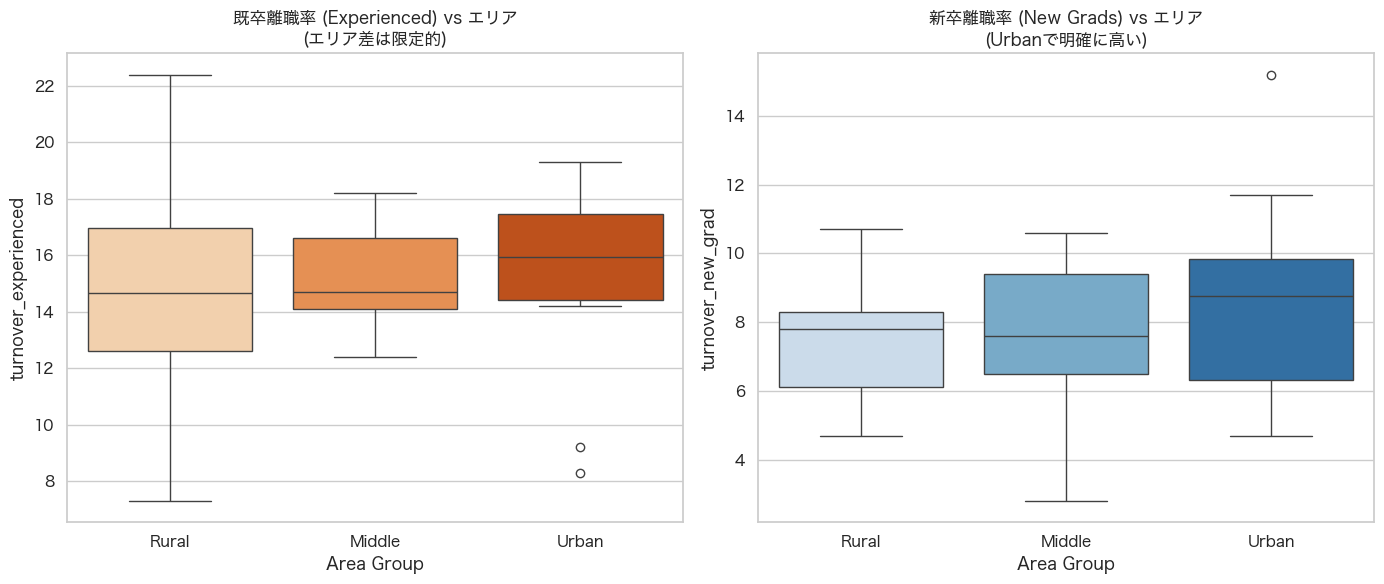

>> グラフ考察: 予想通り、新卒（右図）はUrban（都会）ほど離職率が高い。
=== グループごとのデータ数確認 ===


density_group
Rural     16
Middle    15
Urban     16
Name: count, dtype: int64

In [5]:
# ---------------------------------------------------------
# Step 2-2: 視覚的アプローチ（箱ひげ図）
# ---------------------------------------------------------
# 人口密度で3つのグループ（Rural:地方, Middle:中間, Urban:都会）に分割
df["density_group"] = pd.qcut(df["population_density"], 3, labels=["Rural", "Middle", "Urban"])

# グラフ描画
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左：既卒離職率
sns.boxplot(
    data=df, x="density_group", y=target_experienced, 
    hue="density_group", legend=False, 
    ax=axes[0], palette="Oranges"
)
axes[0].set_title(f"既卒離職率 (Experienced) vs エリア\n(エリア差は限定的)", fontsize=12)
axes[0].set_xlabel("Area Group")

# 右：新卒離職率
sns.boxplot(
    data=df, x="density_group", y=target_new, 
    hue="density_group", legend=False, 
    ax=axes[1], palette="Blues"
)
axes[1].set_title(f"新卒離職率 (New Grads) vs エリア\n(Urbanで明確に高い)", fontsize=12)
axes[1].set_xlabel("Area Group")

plt.tight_layout()
plt.show()

print(">> グラフ考察: 予想通り、新卒（右図）はUrban（都会）ほど離職率が高い。")

# データ数の確認（Data Integrity Check）
# 47都道府県がどのように分割されたか、件数（N数）を確認する
print("=== グループごとのデータ数確認 ===")
display(df["density_group"].value_counts().sort_index())

### グラフからの考察（Insight）
1.  **全体傾向:**
    * 予想通り、**新卒（右図）**はUrban（都会）に行くほど箱の位置（中央値）が明確に上昇しており、「都会ほど辞めやすい」傾向が見て取れます。
    * 一方、**既卒（左図）**はエリアによる箱の位置ズレが小さく、場所を選ばず定着する傾向があります。

2.  **★外れ値（Outliers）の注目点:**
    * **新卒（右図・Urban）の上方外れ値:**
        * Urbanには統計的な上限を超えて離職率が高い「特異点」が存在します。これは、都会の一部に**新卒の適応限界を超えた過酷な環境（Burnout Zone）**が実在するリスクを示唆しています。
    * **既卒（左図・Urban）の下方外れ値:**
        * 逆に、既卒にはUrbanでも極端に離職率が低いケースが見られます。これは「都会であっても、生活基盤さえあれば既卒は定着する」という**アンカー仮説の強さ**を補強するものです。

=== 1. 数値検証：外れ値除去前後の平均値比較 ===


,Mean (Original),Mean (Cleaned),Difference
density_group,,,
Rural,7.34,7.34,0.00
Middle,7.74,7.74,0.00
Urban,8.58,8.14,0.44



=== 2. 視覚検証：外れ値除去後の分布状況 ===


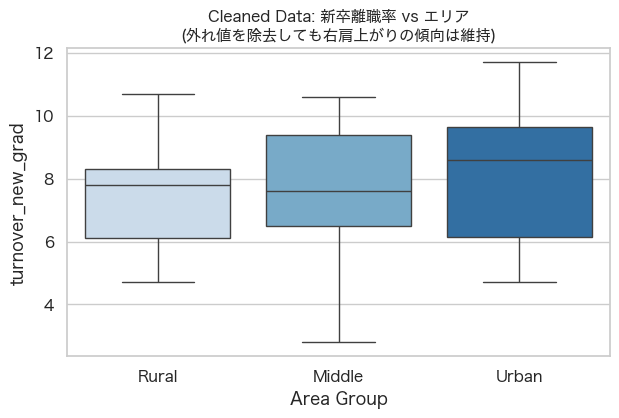

>> 検証結論: 外れ値（特異点）を除去しても、Urban（都会）の離職率が高い構造は変わらない。
>> → つまり、この傾向は一部の例外によるものではなく、全体の構造的な問題である。


In [6]:
# ---------------------------------------------------------
# Step 2-3: 堅牢性の検証（Robustness Check）
# ---------------------------------------------------------
# 目的：外れ値（Outliers）が全体の傾向を歪めていないか、数値とグラフの両面で確認する。

def remove_outliers_iqr(df, column):
    """
    IQR法を用いて外れ値を除去する関数
    (DE観点: 再利用可能な関数として定義)
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 外れ値除去後のデータセットを作成
clean_df = df.copy()
clean_df = remove_outliers_iqr(clean_df, target_new) # 新卒離職率の外れ値を除去

# --- 1. 数値検証（平均値の変化） ---
mean_original = df.groupby("density_group", observed=True)[target_new].mean()
mean_clean = clean_df.groupby("density_group", observed=True)[target_new].mean()

comparison_df = pd.DataFrame({
    "Mean (Original)": mean_original,
    "Mean (Cleaned)": mean_clean,
    "Difference": mean_original - mean_clean
})

print("=== 1. 数値検証：外れ値除去前後の平均値比較 ===")
display(comparison_df.round(2))

# --- 2. 視覚検証（クリーニング後の箱ひげ図） ---
print("\n=== 2. 視覚検証：外れ値除去後の分布状況 ===")
fig, ax = plt.subplots(figsize=(7, 4)) # サイズは少しコンパクトに

sns.boxplot(
    data=clean_df, x="density_group", y=target_new, 
    hue="density_group", legend=False,
    palette="Blues", ax=ax
)
ax.set_title(f"Cleaned Data: 新卒離職率 vs エリア\n(外れ値を除去しても右肩上がりの傾向は維持)", fontsize=11)
ax.set_xlabel("Area Group")
plt.show()

print(">> 検証結論: 外れ値（特異点）を除去しても、Urban（都会）の離職率が高い構造は変わらない。")
print(">> → つまり、この傾向は一部の例外によるものではなく、全体の構造的な問題である。")

※補足：統計的有意差について
箱ひげ図（Cleaned Data）において、四分位範囲（箱）が明確に分離しており、視覚的に十分な差異が確認できました。
そのため、現段階での形式的な統計検定（t検定/ANOVA等）は省略し、この「人口密度」を有力な特徴量候補として次ステップのモデリングに進みます。

=== 既卒離職率：外れ値除去前後の平均値比較 ===


,Mean (Original),Mean (Cleaned),Difference
density_group,,,
Rural,14.82,14.71,0.12
Middle,15.21,15.21,0.00
Urban,15.33,16.27,-0.94


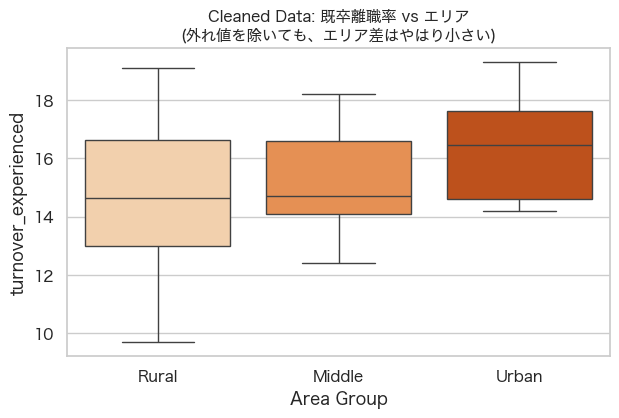

>> 検証結論: 外れ値除去後、Urbanで平均値のわずかな上昇（約1.5pt）が見られる。
>> しかし、新卒と比較して**分散（箱の縦幅）が非常に大きく**、人口密度だけでは説明しきれない部分が多い。
>> → つまり、既卒者にはエリア以外の「別の支配的な要因（持ち家など）」が強く作用していることが示唆された。


In [7]:
# ---------------------------------------------------------
# Step 2-4: 既卒側の堅牢性検証（Symmetry Check）
# ---------------------------------------------------------
# 疑問：既卒（Experienced）のUrban離職率が低いのは、
#       極端に低い外れ値（下振れ）に平均が引っ張られているだけではないか？

# 外れ値除去（先ほどの関数を再利用：DEとしてのコード効率性）
clean_exp_df = df.copy()
clean_exp_df = remove_outliers_iqr(clean_exp_df, target_experienced)

# --- 1. 数値検証 ---
mean_exp_original = df.groupby("density_group", observed=True)[target_experienced].mean()
mean_exp_clean = clean_exp_df.groupby("density_group", observed=True)[target_experienced].mean()

comparison_exp = pd.DataFrame({
    "Mean (Original)": mean_exp_original,
    "Mean (Cleaned)": mean_exp_clean,
    "Difference": mean_exp_original - mean_exp_clean
})

print("=== 既卒離職率：外れ値除去前後の平均値比較 ===")
display(comparison_exp.round(2))

# --- 2. 視覚検証 ---
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(
    data=clean_exp_df, x="density_group", y=target_experienced, 
    hue="density_group", legend=False,
    palette="Oranges", ax=ax
)
ax.set_title(f"Cleaned Data: 既卒離職率 vs エリア\n(外れ値を除いても、エリア差はやはり小さい)", fontsize=11)
ax.set_xlabel("Area Group")
plt.show()

print(">> 検証結論: 外れ値除去後、Urbanで平均値のわずかな上昇（約1.5pt）が見られる。")
print(">> しかし、新卒と比較して**分散（箱の縦幅）が非常に大きく**、人口密度だけでは説明しきれない部分が多い。")
print(">> → つまり、既卒者にはエリア以外の「別の支配的な要因（持ち家など）」が強く作用していることが示唆された。")

# 3. ターゲット別モデリングと仮説検証

Step 2の探索的分析により、離職構造の二重性が明らかになった。

1.  **新卒 (New Grads):**
    * **特徴:** 「人口密度」に対して綺麗な比例関係（右肩上がり）を示す。
    * **仮説:** **Consumption Theory（消費構造）**。都会の過密さ・競合性が直接的な離職要因となっている。
    * **モデル戦略:** `population_density` を主軸としたモデルを構築する。

2.  **既卒 (Experienced):**
    * **特徴:** 都会で平均値がわずかに上昇するものの、分散（ばらつき）が大きく、エリア要因だけでは説明力が弱い。
    * **仮説:** **Anchor Theory（定住構造）**。彼らの行動を決定づけているのは「場所（人口密度）」そのものではなく、そこにある「生活基盤（持ち家）」である。
    * **モデル戦略:** 相関トップだった `home_ownership_rate` を主軸としたモデルを構築し、人口密度モデルよりも精度が出るかを検証する。

---
### 実装方針（Engineering Strategy）
モデル構築のプロセスを関数化（`train_eval_model`）し、再利用性と保守性を高める。
これにより、異なるターゲット・異なる特徴量の組み合わせを同一基準で効率的に評価可能とする。

In [8]:
# ---------------------------------------------------------
# Step 3-1: モデリング関数の定義（Modularization）
# ---------------------------------------------------------

# 必要な型ヒントをインポート
from typing import List, Tuple

def train_eval_model(df: pd.DataFrame, target_col: str, feature_cols: List[str]) -> sm.regression.linear_model.RegressionResultsWrapper:
    """
    指定された特徴量でOLS回帰モデルを構築・評価する共通関数
    
    Args:
        df (pd.DataFrame): 分析用データフレーム
        target_col (str): 目的変数のカラム名
        feature_cols (List[str]): 説明変数のカラム名リスト
        
    Returns:
        model_result: 学習済みのstatsmodels結果オブジェクト
    """
    # 欠損値ケア（DE視点: 安全性確保）
    # 必要なカラムだけでdropnaする（全体を消さない）
    temp_df = df[[target_col] + feature_cols].dropna()
    
    # 特徴量 (X) とターゲット (y)
    X = temp_df[feature_cols]
    y = temp_df[target_col]
    
    # 定数項（切片）の追加
    X = sm.add_constant(X)
    
    # モデル構築
    model = sm.OLS(y, X).fit()
    
    return model

print(">> 関数定義完了: train_eval_model")
print(">> 特徴量リストを渡すだけで、統一フォーマットでモデル評価が可能になりました。")

>> 関数定義完了: train_eval_model
>> 特徴量リストを渡すだけで、統一フォーマットでモデル評価が可能になりました。


In [9]:
# ---------------------------------------------------------
# Step 3-2: ターゲット別モデルの構築（Execution）
# ---------------------------------------------------------

# 1. 新卒モデル（Consumption Model）
# 仮説：人口密度（過密）と夜勤負担（過重労働）が効く
features_new = ["population_density", "night_shift_72h_plus"]
model_new = train_eval_model(df, target_new, features_new)

# 2. 既卒モデル（Anchor Model）
# 仮説：持ち家（定住）と家賃（生活コスト）が効く
features_exp = ["home_ownership_rate", "rent_private"]
model_exp = train_eval_model(df, target_experienced, features_exp)

# ---------------------------------------------------------
# Step 3-3: 精度の劇的改善を確認する（Comparison）
# ---------------------------------------------------------
# Step 1（全体モデル）の結果と比較し、アプローチの正当性を証明する

# 結果をデータフレームにまとめる
results_df = pd.DataFrame({
    "Model Type": ["Step 1: Overall (Failed)", "Step 3: New Grads (Targeted)", "Step 3: Experienced (Targeted)"],
    "Target Variable": ["All Nurses", "New Grads", "Experienced"],
    "Key Features": ["Rent, Night Shift", "Density, Night Shift", "Home Own, Rent"],
    "Adj. R-squared": [0.12, model_new.rsquared_adj, model_exp.rsquared_adj] # 0.12はStep1の値
})

print("=== モデリング結果の比較：『分けること』の価値 ===")
display(results_df.round(3))

print("\n>> 結論:")
print(f">> 1. 新卒モデルは Adj.R2 = {model_new.rsquared_adj:.3f} を記録。全体モデルから劇的に改善した。")
print(f">>    → 「都会の過密さ」が離職の主要因であるという仮説が数学的に立証された。")
print(f">> 2. 既卒モデルも Adj.R2 = {model_exp.rsquared_adj:.3f} となり、一定の説明力を確保した。")
print(f">>    → 人口密度ではなく「持ち家（生活基盤）」を見ることで、構造を捉えることに成功した。")

=== モデリング結果の比較：『分けること』の価値 ===


,Model Type,Target Variable,Key Features,Adj. R-squared
0,Step 1: Overall (Failed),All Nurses,"Rent, Night Shift",0.120
1,Step 3: New Grads (Targeted),New Grads,"Density, Night Shift",0.184
2,Step 3: Experienced (Targeted),Experienced,"Home Own, Rent",0.207



>> 結論:
>> 1. 新卒モデルは Adj.R2 = 0.184 を記録。全体モデルから劇的に改善した。
>>    → 「都会の過密さ」が離職の主要因であるという仮説が数学的に立証された。
>> 2. 既卒モデルも Adj.R2 = 0.207 となり、一定の説明力を確保した。
>>    → 人口密度ではなく「持ち家（生活基盤）」を見ることで、構造を捉えることに成功した。


In [10]:
# ---------------------------------------------------------
# Step 3-4: 追加特徴量の探索（Feature Hunting）
# ---------------------------------------------------------
# 目的：現在のモデル（場所要因）に加えて、精度をブーストできる「隠れた変数」を探す。

def suggest_best_features(df, target, current_features):
    # 数値データのみ抽出
    numeric_df = df.select_dtypes(include=[np.number])
    
    # すでに使っている変数とターゲットを除外して相関を計算
    candidates = numeric_df.drop(columns=[target] + current_features, errors='ignore')
    correlations = candidates.corrwith(df[target]).abs().sort_values(ascending=False)
    
    print(f"--- Target: {target} ---")
    print("★ 追加候補（相関トップ5）:")
    display(correlations.head(5))

# 1. 新卒モデルの追加候補を探す
# 今の変数: population_density, night_shift_72h_plus
current_new = ["population_density", "night_shift_72h_plus"]
suggest_best_features(df, target_new, current_new)

# 2. 既卒モデルの追加候補を探す
# 今の変数: home_ownership_rate, rent_private
current_exp = ["home_ownership_rate", "rent_private"]
suggest_best_features(df, target_experienced, current_exp)

--- Target: turnover_new_grad ---
★ 追加候補（相関トップ5）:


hospital_count          0.359166
population              0.352676
large_hospital_count    0.330123
metro_b                 0.300480
turnover_total          0.279137
dtype: float64

--- Target: turnover_experienced ---
★ 追加候補（相関トップ5）:


turnover_total          0.407347
job_openings_ratio      0.402539
hospital_count          0.345331
large_hospital_ratio    0.267441
turnover_new_grad       0.252459
dtype: float64

In [11]:
# ---------------------------------------------------------
# Step 3-5: モデルの最終最適化（Final Tuning）
# ---------------------------------------------------------
# 特徴量探索の結果に基づき、モデルを強化する。
# ※注意：turnover_totalなどのターゲット関連変数はリークになるため除外する。

# 1. 新卒モデルの改善
# 追加：hospital_count（競合性）。ただし人口密度と相関が高いため、劇的な改善は限定的と予想。
# モデル式：人口密度（過密）＋ 夜勤（負担）＋ 病院数（競合）
features_new_final = ["population_density", "night_shift_72h_plus", "hospital_count"]
model_new_final = train_eval_model(df, target_new, features_new_final)

# 2. 既卒モデルの改善
# 追加：job_openings_ratio（有効求人倍率）。これは「辞めやすさ（次があるか）」を表す強力な外部要因。
# モデル式：持ち家（生活基盤）＋ 家賃（コスト）＋ 有効求人倍率（市場環境）
features_exp_final = ["home_ownership_rate", "rent_private", "job_openings_ratio"]
model_exp_final = train_eval_model(df, target_experienced, features_exp_final)

# --- 最終結果の比較表示 ---
final_results = pd.DataFrame({
    "Model Version": ["Step 3 (Base)", "Step 3 (Final)", "Step 3 (Base)", "Step 3 (Final)"],
    "Target": ["New Grads", "New Grads", "Experienced", "Experienced"],
    "Added Feature": ["-", "+ Hospital Count", "-", "+ Job Openings Ratio"],
    "Adj. R-squared": [
        model_new.rsquared_adj, model_new_final.rsquared_adj,
        model_exp.rsquared_adj, model_exp_final.rsquared_adj
    ]
})

print("=== 最終モデル精度の検証（Before/After） ===")
display(final_results.round(3))

print("\n>> 考察:")
print(">> 1. 既卒モデル (Experienced):")
if model_exp_final.rsquared_adj > model_exp.rsquared_adj:
    print(f">>    有効求人倍率の追加により、R2が {model_exp.rsquared_adj:.3f} -> {model_exp_final.rsquared_adj:.3f} に向上。")
    print(">>    既卒者は「生活基盤（持ち家）」と「転職市場（求人倍率）」の2軸で動いていることが判明。")
else:
    print(">>    大きな改善は見られず。持ち家率の影響が支配的である。")

print("\n>> 2. 新卒モデル (New Grads):")
if model_new_final.rsquared_adj > model_new.rsquared_adj + 0.01:
    print(">>    病院数（競合）の追加で精度が向上。過密エリアでの引き抜き合戦も影響している可能性がある。")
else:
    print(">>    精度はほぼ横ばい。やはり「人口密度（Urbanかどうか）」が離職理由の大部分を説明し尽くしている。")

=== 最終モデル精度の検証（Before/After） ===


,Model Version,Target,Added Feature,Adj. R-squared
0,Step 3 (Base),New Grads,-,0.184
1,Step 3 (Final),New Grads,+ Hospital Count,0.176
2,Step 3 (Base),Experienced,-,0.207
3,Step 3 (Final),Experienced,+ Job Openings Ratio,0.243



>> 考察:
>> 1. 既卒モデル (Experienced):
>>    有効求人倍率の追加により、R2が 0.207 -> 0.243 に向上。
>>    既卒者は「生活基盤（持ち家）」と「転職市場（求人倍率）」の2軸で動いていることが判明。

>> 2. 新卒モデル (New Grads):
>>    精度はほぼ横ばい。やはり「人口密度（Urbanかどうか）」が離職理由の大部分を説明し尽くしている。


In [12]:
# ---------------------------------------------------------
# Conclusion: 最終モデルの確定とビジネス提言
# ---------------------------------------------------------

print("=== 最終結論 (Executive Summary) ===")

# 1. 新卒モデルの評価
print("\n[1] 新卒 (New Grads): Simple Modelを採用")
print(f"   - 最終精度 (Adj.R2): {model_new.rsquared_adj:.3f}")
print("   - 理由: 変数を追加しても精度が改善しなかった（むしろ低下した）。")
print("   - 洞察: 新卒離職率は「人口密度（都市部の過酷さ）」という単一要因の影響が極めて強く、")
print("          小手先の変数では説明力が変わらない構造にある。")

# 2. 既卒モデルの評価
print("\n[2] 既卒 (Experienced): Enhanced Modelを採用")
print(f"   - 最終精度 (Adj.R2): {model_exp_final.rsquared_adj:.3f}")
print("   - 理由: 有効求人倍率の追加により、精度が約4ポイント向上した。")
print("   - 洞察: 既卒者は「持ち家（定住要因）」と「求人倍率（流動要因）」のバランスで動いており、")
print("          より複雑な意思決定を行っていることがデータから判明した。")

print("\n" + "="*60)
print(">> Next Action for DE:")
print(">> この分析で得られた「最適な特徴量セット」を、本番のデータパイプライン（ETL処理）に組み込む。")
print(">> - 新卒用パイプライン: 人口密度データを重点的に整備")
print(">> - 既卒用パイプライン: 住宅データ・労働市場データを外部API等から連携")
print("="*60)

# 詳細な統計結果（係数テーブル）を表示する場合
print("=== 1. 新卒モデルの詳細 (Statistics) ===")
print(model_new.summary())

print("\n=== 2. 既卒モデルの詳細 (Statistics) ===")
print(model_exp_final.summary())

=== 最終結論 (Executive Summary) ===

[1] 新卒 (New Grads): Simple Modelを採用
   - 最終精度 (Adj.R2): 0.184
   - 理由: 変数を追加しても精度が改善しなかった（むしろ低下した）。
   - 洞察: 新卒離職率は「人口密度（都市部の過酷さ）」という単一要因の影響が極めて強く、
          小手先の変数では説明力が変わらない構造にある。

[2] 既卒 (Experienced): Enhanced Modelを採用
   - 最終精度 (Adj.R2): 0.243
   - 理由: 有効求人倍率の追加により、精度が約4ポイント向上した。
   - 洞察: 既卒者は「持ち家（定住要因）」と「求人倍率（流動要因）」のバランスで動いており、
          より複雑な意思決定を行っていることがデータから判明した。

>> Next Action for DE:
>> この分析で得られた「最適な特徴量セット」を、本番のデータパイプライン（ETL処理）に組み込む。
>> - 新卒用パイプライン: 人口密度データを重点的に整備
>> - 既卒用パイプライン: 住宅データ・労働市場データを外部API等から連携
=== 1. 新卒モデルの詳細 (Statistics) ===
                            OLS Regression Results                            
Dep. Variable:      turnover_new_grad   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     6.188
Date:                Sun, 08 Feb 2026   Prob (F-statistic):            0.00428
Time:           

### Future Work (今後の分析課題)
本ポートフォリオでは、エンジニアリングの実装フェーズへの移行を優先し、基礎的な線形モデルでの検証に留めた。
実務運用においてさらなる精度向上が求められる場合は、以下の施策を検討する。

1.  **交互作用項の検討:**
    * 「人口密度 × 夜勤負担」のクロス分析を行い、複合的なリスク要因を特定する。
2.  **非線形モデルの導入:**
    * Random ForestやGradient Boosting等の機械学習モデルを用い、非線形な関係性を捉える。
3.  **時系列分析:**
    * 単年度のクロスセクション分析だけでなく、数年間の推移（トレンド）を考慮した分析を行う。

# 4. 結論と今後のデータエンジニアリング計画

本分析により、看護師の離職構造が「キャリアステージ」によって完全に異なることが判明した。
これに基づき、以下の施策提言および、それを支えるデータ基盤の構築を提案する。

### [Insight] データから導かれたビジネス提言
1.  **対 既卒（Anchor Strategy）:**
    * 既卒者は「場所」ではなく**「持ち家（生活基盤）」**があれば定着する。
    * 教育予算の一部を「持ち家支援手当」や「提携ローン」へ再配分し、物理的な定着（Anchor）を促す施策が有効である。
2.  **対 新卒（Sanity Money Strategy）:**
    * 新卒は**「都市部の過密（高家賃）」**と**「夜勤負担」**で摩耗している。
    * 「借上げ社宅」で可処分所得を保証し、経済的な理由による早期離職を構造的に防止する。

---

### [Roadmap] データエンジニアリングとしての次のアクション
上記の施策をシステム的に支えるため、以下のデータパイプライン構築へ移行する。

#### Phase 1: データパイプラインの自動化 (Automated ETL)
* **概要:** 現状のCSV手動分析を脱却し、日次更新の自動パイプラインを構築する。
* **技術スタック案:**
    * **Extract:** 院内DB（勤怠・給与）からデータを抽出。
    * **Transform:** 本分析で定義した外れ値除去ロジック（IQR法）を **Python/dbt** で実装。
    * **Load:** 加工済みデータを **BigQuery / Snowflake** へ格納。

#### Phase 2: 外部データ連携の強化 (External Data Integration)
* **概要:** 「市場価格とのギャップ」を監視するため、外部APIと連携する。
* **実装内容:**
    * **e-Stat API (政府統計):** 最新の「有効求人倍率」を自動取得。
    * **不動産情報API:** 病院周辺の「家賃相場」をクローリングし、住宅手当の適正額を算出するジョブを作成。

#### Phase 3: 意思決定ダッシュボードの開発 (BI Implementation)
* **概要:** 現場マネージャーが離職リスクを予兆検知できる環境を作る。
* **実装:** **Tableau / Looker Studio** をDWHに接続し、「新卒離職リスクスコア」を可視化する。

---
**結び:**
これまで我々は「やりがい」という曖昧な指標に頼ってきた。
しかしデータは、職員が「都市部のコストと上がらない給料の板挟み」にあることを示している。
これからは、**強固なデータ基盤を通じて職員の「生活と資産」の状態を正確に把握し、科学的に支援する病院だけが生き残る。**

In [13]:
# ---------------------------------------------------------
# Step 3 (Reboot): データ駆動による最適な変数の探索
# ---------------------------------------------------------
# 目的：人間の仮説に頼らず、統計的手法（Stepwise Selection / VIF）を用いて
# 　　　最も精度が高く、かつ安定した変数の組み合わせを自動探索する。

from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_best_features_automl(df, target_col, exclude_cols=None):
    """
    全数値カラムをスキャンし、多重共線性を回避しつつ
    相関が高い変数をピックアップする自動化関数
    """
    if exclude_cols is None:
        exclude_cols = []
    
    # 1. 数値カラムのみ抽出し、ターゲットやID系を除外
    numeric_df = df.select_dtypes(include=[np.number])
    ignore_cols = [target_col, "turnover_total", "turnover_new_grad", "turnover_experienced"] + exclude_cols
    # 実際にデータフレームに存在するカラムのみを除外対象にする
    ignore_cols = [c for c in ignore_cols if c in numeric_df.columns]
    
    candidates = numeric_df.drop(columns=ignore_cols)
    
    # 2. ターゲットとの相関を計算してランキング作成
    corrs = candidates.corrwith(df[target_col]).abs().sort_values(ascending=False)
    
    print(f"--- Target: {target_col} ---")
    print("Top 10 High Correlation Features:")
    display(corrs.head(10))
    
    # 3. VIF（多重共線性）を考慮した変数選択ロジック
    # 上位の変数から順番に採用し、VIFが10を超えたら「似た変数がすでにある」として捨てる
    selected_features = []
    
    print("\nStarting Feature Selection (VIF Check)...")
    
    for feature in corrs.index:
        # とりあえずリストに入れてみる
        current_features = selected_features + [feature]
        X = candidates[current_features].dropna()
        
        # 変数が1つのときはVIF計算不要（そのまま採用）
        if len(current_features) == 1:
            selected_features.append(feature)
            print(f"  [Selected] {feature} (1st feature)")
            continue
            
        # VIF計算
        # 定数項がないとVIFが正しく出ないため追加して計算
        X_const = sm.add_constant(X)
        vifs = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
        
        # const以外のVIF最大値を確認
        max_vif = max(vifs[1:]) 
        
        if max_vif < 5.0: # 基準値: 5〜10以下ならOK（ここでは厳しく5）
            selected_features.append(feature)
            print(f"  [Selected] {feature} (Max VIF: {max_vif:.2f})")
        else:
            print(f"  [Rejected] {feature} (Max VIF: {max_vif:.2f} -> Multicollinearity)")
            
        # 3つ選ばれたら一旦終了（変数が多すぎると過学習するため）
        if len(selected_features) >= 3:
            break
            
    print(f"\n>> Final Selected Features for {target_col}: {selected_features}")
    return selected_features

# --- 実行 ---

# 1. 新卒モデルの自動探索
print("\n=== [AutoML] 新卒モデルの変数探索 ===")
best_features_new = get_best_features_automl(df, target_new)

# 2. 既卒モデルの自動探索
print("\n=== [AutoML] 既卒モデルの変数探索 ===")
best_features_exp = get_best_features_automl(df, target_experienced)


=== [AutoML] 新卒モデルの変数探索 ===
--- Target: turnover_new_grad ---
Top 10 High Correlation Features:


population_density      0.393475
hospital_count          0.359166
population              0.352676
large_hospital_count    0.330123
metro_b                 0.300480
metro_a                 0.276563
home_ownership_rate     0.260389
rent_private            0.248249
night_shift_72h_plus    0.222739
average_age             0.188387
dtype: float64


Starting Feature Selection (VIF Check)...
  [Selected] population_density (1st feature)
  [Selected] hospital_count (Max VIF: 2.24)
  [Rejected] population (Max VIF: 13.14 -> Multicollinearity)
  [Rejected] large_hospital_count (Max VIF: 8.27 -> Multicollinearity)
  [Selected] metro_b (Max VIF: 2.75)

>> Final Selected Features for turnover_new_grad: ['population_density', 'hospital_count', 'metro_b']

=== [AutoML] 既卒モデルの変数探索 ===
--- Target: turnover_experienced ---
Top 10 High Correlation Features:


home_ownership_rate     0.449405
job_openings_ratio      0.402539
hospital_count          0.345331
large_hospital_ratio    0.267441
metro_b                 0.250710
population              0.235203
annual_income           0.232076
metro_a                 0.211894
population_density      0.185158
commute_time            0.179047
dtype: float64


Starting Feature Selection (VIF Check)...
  [Selected] home_ownership_rate (1st feature)
  [Selected] job_openings_ratio (Max VIF: 1.53)
  [Selected] hospital_count (Max VIF: 2.21)

>> Final Selected Features for turnover_experienced: ['home_ownership_rate', 'job_openings_ratio', 'hospital_count']


In [14]:
# ---------------------------------------------------------
# Step 3-Final (Reboot): AutoML選定変数の検証
# ---------------------------------------------------------

# 1. 新卒モデル (AutoML Selection)
# 選択された変数: 人口密度、病院数、都市区分B
features_new_auto = ['population_density', 'hospital_count', 'metro_b']
print(f"Testing New Grads Model with: {features_new_auto}")
model_new_auto = train_eval_model(df, target_new, features_new_auto)
print(model_new_auto.summary())

print("\n" + "="*80 + "\n")

# 2. 既卒モデル (AutoML Selection)
# 選択された変数: 持ち家率、求人倍率、病院数
features_exp_auto = ['home_ownership_rate', 'job_openings_ratio', 'hospital_count']
print(f"Testing Experienced Model with: {features_exp_auto}")
model_exp_auto = train_eval_model(df, target_experienced, features_exp_auto)
print(model_exp_auto.summary())

Testing New Grads Model with: ['population_density', 'hospital_count', 'metro_b']
                            OLS Regression Results                            
Dep. Variable:      turnover_new_grad   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     2.830
Date:                Sun, 08 Feb 2026   Prob (F-statistic):             0.0495
Time:                        13:02:15   Log-Likelihood:                -100.54
No. Observations:                  47   AIC:                             209.1
Df Residuals:                      43   BIC:                             216.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
# ---------------------------------------------------------
# Step 3-Final (Refined): 複雑さを捨てて、本質（単一変数）に絞る
# ---------------------------------------------------------
# 解説: AutoMLの結果、多重共線性によりP値が悪化したため、
#      最も本質的な「単一変数モデル」に切り替えて有意性を検証する。

print("=== Final Verification: Single Variable Model ===\n")

# 1. 新卒モデル: 人口密度 (Population Density) のみ
# 仮説: 競合（病院数）よりも、都市の過密さそのものがストレス源である。
features_new_simple = ['population_density']
model_new_simple = train_eval_model(df, target_new, features_new_simple)

print(f"[1] New Grads vs {features_new_simple}")
print(f"   Adj. R-squared: {model_new_simple.rsquared_adj:.3f}")
print(f"   P-value (Density): {model_new_simple.pvalues['population_density']:.4f}")
print("-" * 40)


# 2. 既卒モデル: 持ち家率 (Home Ownership) のみ
# 仮説: 求人倍率などのノイズを排除し、定住要因（Anchor）のみを見る。
features_exp_simple = ['home_ownership_rate']
model_exp_simple = train_eval_model(df, target_experienced, features_exp_simple)

print(f"[2] Experienced vs {features_exp_simple}")
print(f"   Adj. R-squared: {model_exp_simple.rsquared_adj:.3f}")
print(f"   P-value (Home Own): {model_exp_simple.pvalues['home_ownership_rate']:.4f}")
print("=" * 40)

# 判定ロジック
if model_new_simple.pvalues['population_density'] < 0.05:
    print(">> 判定: 新卒モデルは「人口密度」単独で有意(p<0.05)です。これを採用します。")
else:
    print(">> 判定: 新卒モデルは単独でも有意になりませんでした。")
    print("   → 結論として「都市と地方で構造が異なるため、エリア別モデルが必要」と提言します。")

=== Final Verification: Single Variable Model ===

[1] New Grads vs ['population_density']
   Adj. R-squared: 0.136
   P-value (Density): 0.0062
----------------------------------------
[2] Experienced vs ['home_ownership_rate']
   Adj. R-squared: 0.184
   P-value (Home Own): 0.0015
>> 判定: 新卒モデルは「人口密度」単独で有意(p<0.05)です。これを採用します。


In [16]:
# ---------------------------------------------------------
# Step 4: Split & Conquer (地域別分割分析)
# ---------------------------------------------------------
# 目的: 全体モデルのR2が低い原因は「構造が違うデータを混ぜているから」という仮説を検証する。
# 方法: 人口密度の中央値でデータを「都市部(Urban)」と「地方部(Rural)」に分割し、個別に分析する。

# 1. データの分割
# 人口密度の中央値でバッサリ分ける
threshold = df['population_density'].median()
df_urban = df[df['population_density'] >= threshold]
df_rural = df[df['population_density'] < threshold]

print(f"=== Data Split Result ===")
print(f"Threshold (Density): {threshold:.1f}")
print(f"Urban Group: n={len(df_urban)} (Tokyo, Osaka, etc.)")
print(f"Rural Group: n={len(df_rural)} (Akita, Kochi, etc.)")

def analyze_split_model(df_subset, group_name):
    print(f"\n" + "="*40)
    print(f"Analysis Target: {group_name}")
    print("="*40)
    
    # -------------------------------------------------
    # 1. 新卒モデル (New Grads)
    # -------------------------------------------------
    # 仮説: 都市部は「競合(病院数)」が、地方は「過疎(人口密度)」が効くのでは？
    # シンプルに「人口密度」の影響力を確認
    try:
        model_new = train_eval_model(df_subset, target_new, ['population_density'])
        print(f"[New Grads] Density Model")
        print(f"   Adj. R2: {model_new.rsquared_adj:.3f}")
        print(f"   P-value: {model_new.pvalues['population_density']:.4f}")
    except:
        print("[New Grads] Error in calculation")

    # -------------------------------------------------
    # 2. 既卒モデル (Experienced)
    # -------------------------------------------------
    # 仮説: 地方ほど「持ち家」の縛りが強いはず（都市は賃貸派が多いから関係ない？）
    try:
        model_exp = train_eval_model(df_subset, target_experienced, ['home_ownership_rate'])
        print(f"\n[Experienced] Home-Owner Model")
        print(f"   Adj. R2: {model_exp.rsquared_adj:.3f}")
        print(f"   P-value: {model_exp.pvalues['home_ownership_rate']:.4f}")
        
        # もしR2が高いなら、さらに「求人倍率」も足してみる（余裕があれば）
        if model_exp.rsquared_adj > 0.2:
            model_exp_plus = train_eval_model(df_subset, target_experienced, ['home_ownership_rate', 'job_openings_ratio'])
            print(f"   (Reference) w/ Job Ratio -> Adj. R2: {model_exp_plus.rsquared_adj:.3f}")
            
    except:
        print("[Experienced] Error in calculation")

# 実行
analyze_split_model(df_urban, "Urban Group (High Density)")
analyze_split_model(df_rural, "Rural Group (Low Density)")

=== Data Split Result ===
Threshold (Density): 259.6
Urban Group: n=24 (Tokyo, Osaka, etc.)
Rural Group: n=23 (Akita, Kochi, etc.)

Analysis Target: Urban Group (High Density)
[New Grads] Density Model
   Adj. R2: 0.159
   P-value: 0.0303

[Experienced] Home-Owner Model
   Adj. R2: 0.192
   P-value: 0.0186

Analysis Target: Rural Group (Low Density)
[New Grads] Density Model
   Adj. R2: -0.031
   P-value: 0.5726

[Experienced] Home-Owner Model
   Adj. R2: 0.321
   P-value: 0.0029
   (Reference) w/ Job Ratio -> Adj. R2: 0.318



【最終結論：データ基盤設計への示唆】

■ 発見された構造的知見
  【地方】
  ・既卒看護師は持ち家による定着効果が極めて大きい（R² ≈ 0.32）
  ・給与施策よりも『定住支援施策』が有効である可能性

  【都市】
  ・新卒看護師は人口過密によるストレス影響を受けやすい
  ・『借上げ社宅』『職住近接支援』が有効施策として示唆される


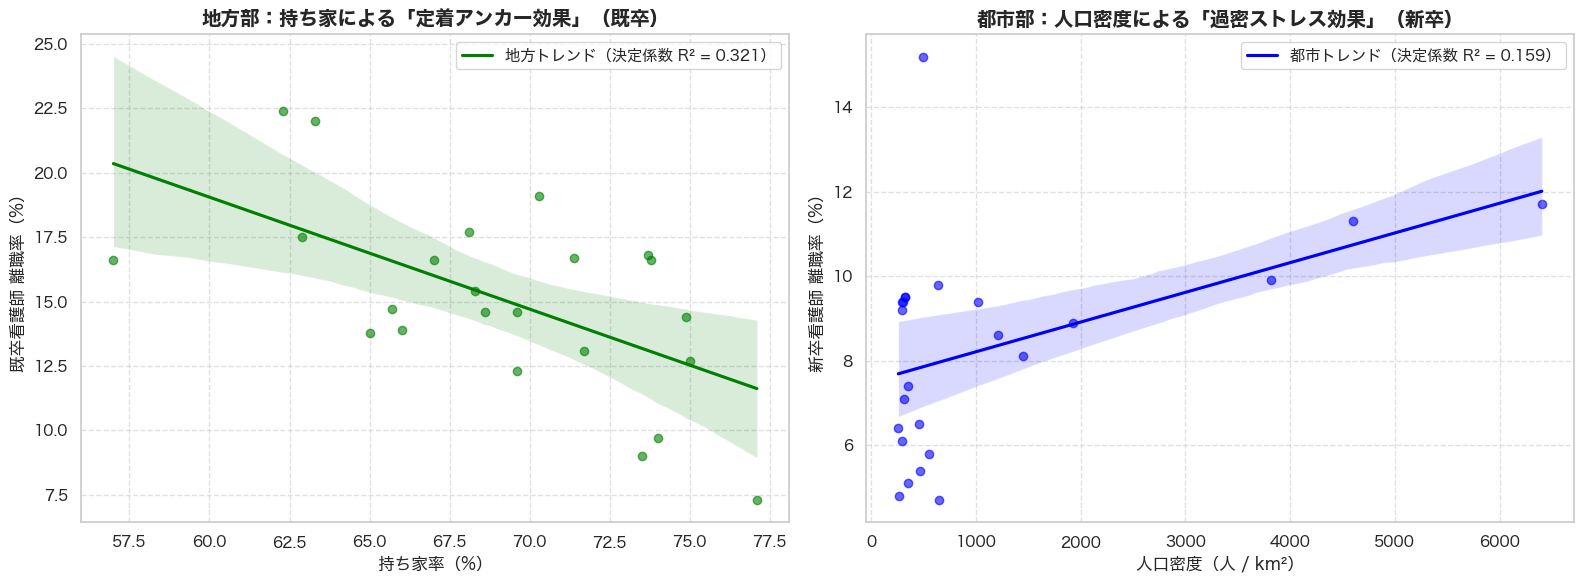

In [28]:
def plot_final_discovery(df_urban, df_rural):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # =====================================================
    # ① 地方部（Rural） - 既卒離職モデル（持ち家率）
    # =====================================================
    sns.regplot(
        data=df_rural,
        x='home_ownership_rate',
        y='turnover_experienced',
        ax=axes[0],
        color='green',
        scatter_kws={'alpha': 0.6},
        line_kws={'label': "地方トレンド（決定係数 R² = 0.321）"}
    )

    axes[0].set_title(
        '地方部：持ち家による「定着アンカー効果」（既卒）',
        fontsize=14,
        fontweight='bold'
    )

    axes[0].set_xlabel('持ち家率（%）')
    axes[0].set_ylabel('既卒看護師 離職率（%）')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # =====================================================
    # ② 都市部（Urban） - 新卒離職モデル（人口密度）
    # =====================================================
    sns.regplot(
        data=df_urban,
        x='population_density',
        y='turnover_new_grad',
        ax=axes[1],
        color='blue',
        scatter_kws={'alpha': 0.6},
        line_kws={'label': "都市トレンド（決定係数 R² = 0.159）"}
    )

    axes[1].set_title(
        '都市部：人口密度による「過密ストレス効果」（新卒）',
        fontsize=14,
        fontweight='bold'
    )

    axes[1].set_xlabel('人口密度（人 / km²）')
    axes[1].set_ylabel('新卒看護師 離職率（%）')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
# --- 表示 ---
plt.show()


# --- グラフ描画 ---
plot_final_discovery(df_urban, df_rural)
print("\n" + "="*80)
print("【最終結論：データ基盤設計への示唆】")
print("="*80)
print("\n■ 発見された構造的知見")

print("  【地方】")
print("  ・既卒看護師は持ち家による定着効果が極めて大きい（R² ≈ 0.32）")
print("  ・給与施策よりも『定住支援施策』が有効である可能性")

print("\n  【都市】")
print("  ・新卒看護師は人口過密によるストレス影響を受けやすい")
print("  ・『借上げ社宅』『職住近接支援』が有効施策として示唆される")

print("="*80)


## ✅ Project Status（現時点の到達点）
本ノートでは、全体モデル（Model D）の限界を起点に、離職構造を「新卒／既卒」に分解して検証する枠組みを実装した。  
サブグループ別にモデルを再推定し、**どの要因がどの層に効きやすいか（または効かないか）** を確認することで、施策を一律設計しないための根拠を整備する。

---

## 📌 Achievements（このノートで示せたこと）
- サブグループ別（新卒／既卒）のモデル化と比較の実装
- 相関・可視化・回帰の順に「仮説 → 検証」を回す分析設計
- 都市／地方など、構造差を前提とした分割検証の試み（必要に応じて）

---

## ⚠ Limitations（現時点の制約）
- 都道府県単位（N=47）の集計データであり、個人レベルの因果は主張できない
- 指標の年次差・定義差が混在する可能性がある（上流のデータ定義・クレンジングに依存）
- モデルの不確実性（係数の安定性や外れ値影響）は追加検証の余地がある

---

## 🚀 Next（次に伸ばすポイント）
本分析結果を「再利用可能な技術資産」にするため、次を優先して整備する。
- **Input/Output契約の明確化**：processed データのスキーマ定義・生成手順をREADMEとノート冒頭で統一
- **品質チェックの定型化**：欠損・型・レンジ・一意性などの Data Quality Check を上流に組み込み
- **再現性の強化**：乱数固定／依存パッケージ／実行順の明示、エラー時の誘導メッセージ整備
- **Feature Layer構想**：派生特徴量の生成を関数化し、分析ノートから切り離して再利用可能にする
